# Quantum Variational Autoencoder with KL Divergence
This tutorial trains a hybrid QVAE using a quantum circuit encoder and classical decoder with a KL divergence loss component.

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import random

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector


In [2]:

# Set seeds and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

mnist_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
subset = Subset(mnist_data, torch.randperm(len(mnist_data))[:500])
dataloader = DataLoader(subset, batch_size=32, shuffle=True)


In [24]:

# Define classical encoder to generate mu and log_var
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=8):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc(x))
        return self.mu(h), self.log_var(h)


In [26]:

# Define decoder network
class Decoder(nn.Module):
    def __init__(self, latent_dim=8, hidden_dim=128, output_dim=784):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))


In [27]:

# Quantum circuit
latent_dim = 8
inputs = ParameterVector("x", latent_dim)
params = ParameterVector("θ", latent_dim * 3)
qc = QuantumCircuit(latent_dim)

for i in range(latent_dim):
    qc.ry(inputs[i], i)
for i in range(latent_dim):
    qc.rx(params[i], i)
    qc.ry(params[i + latent_dim], i)
for i in range(latent_dim - 1):
    qc.cz(i, i+1)
for i in range(latent_dim):
    qc.rz(params[i + 2*latent_dim], i)

observables = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(latent_dim-i-1)}", 1)]) for i in range(latent_dim)]
qnn = EstimatorQNN(
    circuit=qc,
    input_params=inputs,
    weight_params=params,
    observables=observables,
    estimator=Estimator()
)
quantum_layer = TorchConnector(qnn).to(device)



C:\Users\ruhiy\AppData\Local\Temp\ipykernel_18684\624397356.py:23: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator=Estimator()
C:\Users\ruhiy\AppData\Local\Temp\ipykernel_18684\624397356.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [28]:

# Instantiate models
encoder = Encoder().to(device)
decoder = Decoder().to(device)
params = list(encoder.parameters()) + list(decoder.parameters()) + list(quantum_layer.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)


In [29]:

# KL divergence and training loop
def kl_divergence(mu, log_var):
    return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

def train_qvae(epochs=5):
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()

            mu, log_var = encoder(x)
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            z = mu + eps * std

            zq = quantum_layer(torch.tanh(z))
            x_hat = decoder(zq)

            recon_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
            kl = kl_divergence(mu, log_var)
            beta = 0.001
            loss = recon_loss + beta * kl

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader.dataset):.4f}")


In [30]:
train_qvae(epochs=2)

Epoch 1, Loss: 492.3368
Epoch 2, Loss: 378.5677


mu  tensor([[-3.0538e-02,  1.8924e-03, -1.7229e-02, -4.9957e-03,  7.8610e-03,
          5.1756e-03,  5.4802e-03,  1.6396e-02],
        [-2.1313e-02,  3.1784e-03, -2.9234e-03,  5.6030e-03,  9.4997e-04,
         -8.7996e-03, -3.2291e-03, -7.0571e-03],
        [-3.5109e-02,  8.1140e-03, -1.0255e-02, -9.4260e-03, -7.9538e-03,
         -1.0517e-02, -6.3706e-03, -2.5433e-03],
        [-4.2691e-02,  5.0357e-03, -5.8308e-03, -2.3545e-03,  1.0696e-02,
         -3.3947e-02, -4.7778e-03,  3.5255e-03],
        [-1.8198e-02,  1.5696e-02, -3.7420e-03,  1.0748e-02,  1.3974e-02,
          2.1059e-02,  1.7402e-02,  6.9420e-03],
        [-1.2807e-02,  3.7808e-03, -3.4345e-03, -1.2686e-02, -1.4374e-02,
         -3.0529e-02, -7.8947e-03,  9.3208e-03],
        [ 1.5349e-03,  9.4154e-03, -8.8532e-05, -1.7734e-02, -1.3554e-02,
          1.2567e-02,  3.0504e-03,  5.0278e-03],
        [-3.0774e-02,  7.5685e-03, -8.5191e-03,  1.9033e-03,  1.0823e-02,
         -1.8095e-03, -1.9777e-03,  1.7522e-02]])
log_var  te

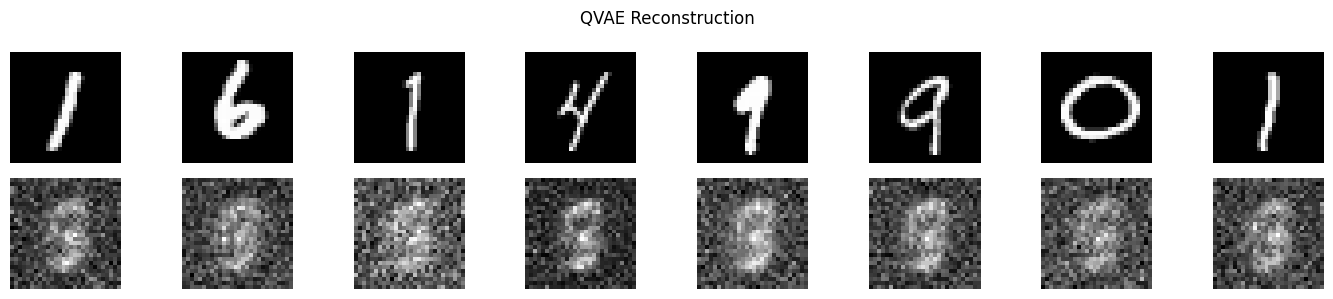

In [41]:

# Visualize
with torch.no_grad():
    sample = next(iter(dataloader))[0][:8].to(device)
    mu, log_var = encoder(sample)
    print("mu ", mu)
    print("log_var ", log_var)
    # z = mu
    z = mu + torch.randn_like(mu) * torch.exp(0.5 * log_var)
    zq = quantum_layer(torch.tanh(z))
    recon = decoder(z)
    # recon = decoder(zq).cpu()

    fig, axes = plt.subplots(2, 8, figsize=(14, 3))
    for i in range(8):
        axes[0, i].imshow(sample[i].view(28, 28).cpu(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(recon[i].view(28, 28), cmap="gray")
        axes[1, i].axis("off")
    axes[0, 0].set_ylabel("Input")
    axes[1, 0].set_ylabel("Recon")
    plt.suptitle("QVAE Reconstruction")
    plt.tight_layout()
    plt.show()
